# Flood Adaptation: Minimal Model

This python script outlines a basic Agent-Based Model (ABM) developed using the Mesa framework, designed as a simplified representation of household adaptation to flood events in a social network context. The model serves as a template for understanding the fundamental mechanics of flood adapdtation with a given social network.

This directory is structured as follows:
 - A Mesa Agent class `Households` is defined in `agents.py`
 - A Mesa Agent class `Government` is defined in `agents.py` (this agent currently does not perform any action)
 - A Mesa Model class `AdaptationModel` is defined in `model.py`
 - This notebook `demo.ipynb` provides a demonstration of the model and its visualization.

Each household agent in the model represents a household with attributes and behaviors that determine its response to flood events. The flood depth attribute assigned to each household is currently random for demonstration purposes. The decision by each household to adapt is also arbitrary. In a more comprehensive model, this could be replaced with more sophisticated decision-making algorithms.

The current implementation includes several simplifications and arbitrary choices, such as random flood depths and basic adaptation logic based on random thresholds. These aspects are designed for clarity and ease of understanding and should be replaced with realistic and sound choices.

You are encouraged to modify, expand, and customize the model. This might include integrating real-world data, implementing more complex decision-making processes for agents, or exploring different network topologies and their effects on social dynamics.

The visualisation provided is basic. Additional aspects can be added for visualization and more in-depth analysis.

_This notebook was tested on 2023-11-13 with Mesa version 2.1.4 on Python 3.12.0._

# Running the model and visualizing the model domain and social network over time

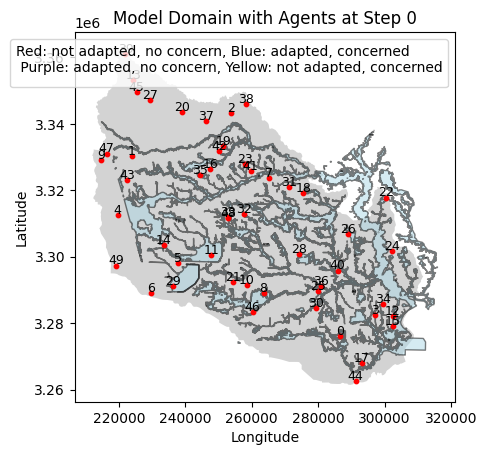

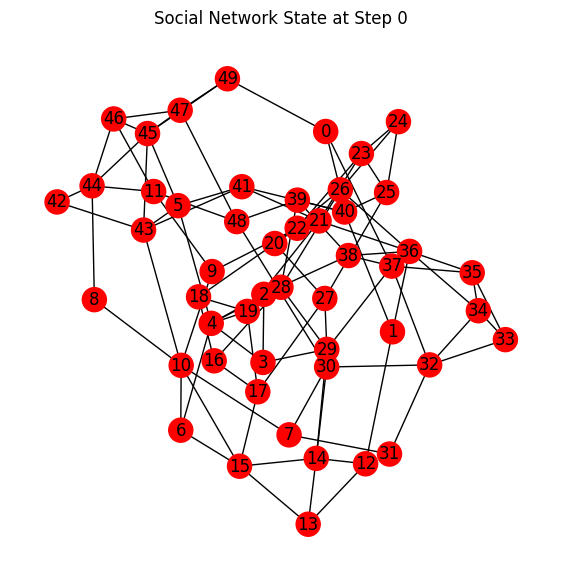

17 changed because of a similarity bias!


<Figure size 1000x600 with 0 Axes>

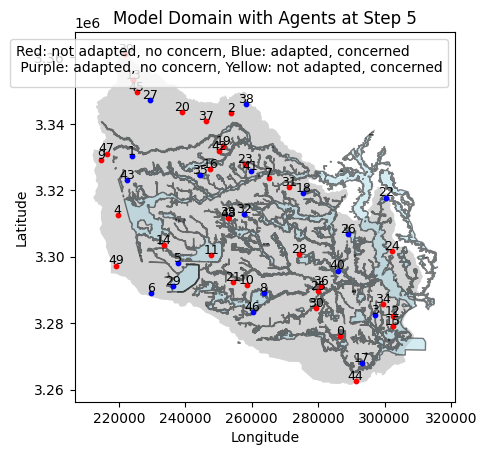

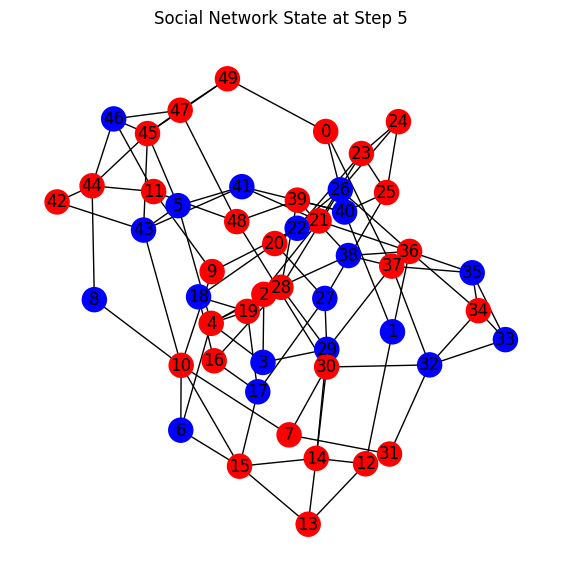

33 changed because of a similarity bias!
43 changed because of a similarity bias!
21 changed because of a similarity bias!


<Figure size 1000x600 with 0 Axes>

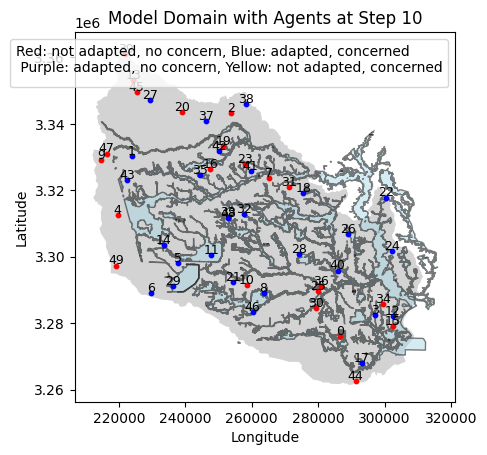

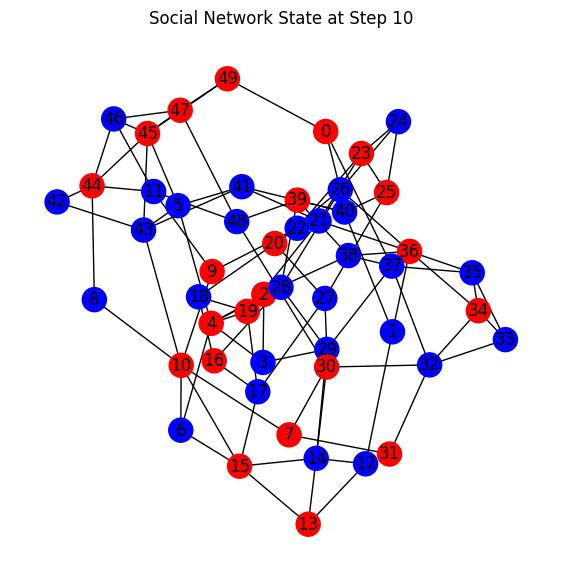

17 changed because of a similarity bias!
41 changed because of a similarity bias!
29 changed because of a similarity bias!
41 changed because of a similarity bias!
35 changed because of a similarity bias!
41 changed because of a similarity bias!
21 changed because of a similarity bias!


<Figure size 1000x600 with 0 Axes>

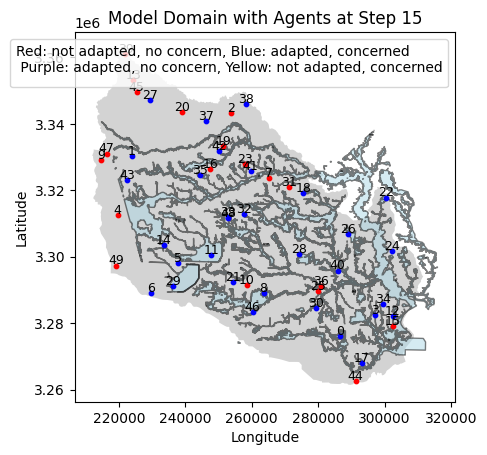

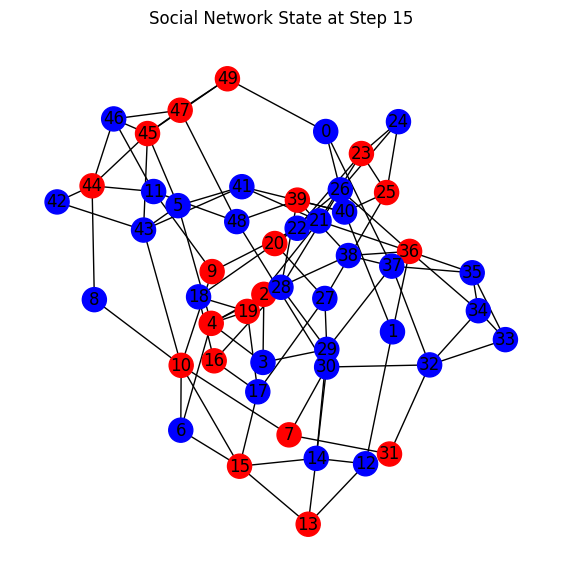

41 changed because of a similarity bias!
17 changed because of a similarity bias!
17 changed because of a similarity bias!
21 changed because of a similarity bias!
33 changed because of a similarity bias!
33 changed because of a similarity bias!
41 changed because of a similarity bias!
33 changed because of a similarity bias!


<Figure size 1000x600 with 0 Axes>

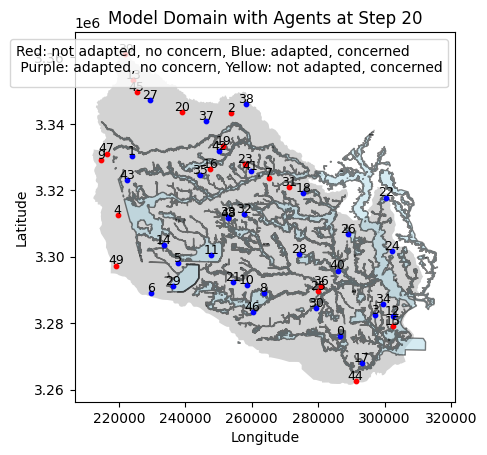

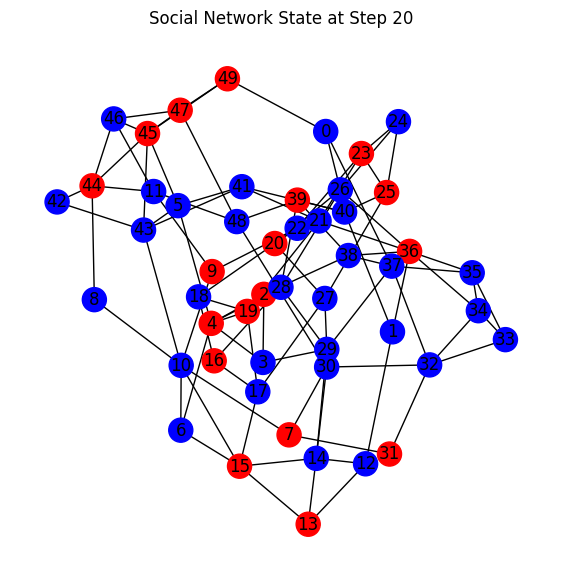

In [1]:
from model import AdaptationModel
import matplotlib.pyplot as plt
import networkx as nx

# Initialize the Adaptation Model with 50 household agents.
model = AdaptationModel(number_of_households=50, flood_map_choice="harvey", network="watts_strogatz") # flood_map_choice can be "harvey", "100yr", or "500yr"

# Calculate positions of nodes for the network plot.
# The spring_layout function positions nodes using a force-directed algorithm,
# which helps visualize the structure of the social network.
pos = nx.spring_layout(model.G)

# Define a function to plot agents on the network.
# This function takes a matplotlib axes object and the model as inputs.
def plot_network(ax, model):
    # Clear the current axes.
    ax.clear()
    # Determine the color of each node (agent) based on their adaptation status.
    colors = ['blue' if agent.is_adapted else 'red' for agent in model.schedule.agents]
    # Draw the network with node colors and labels.
    nx.draw(model.G, pos, node_color=colors, with_labels=True, ax=ax)
    # Set the title of the plot with the current step number.
    ax.set_title(f"Social Network State at Step {model.schedule.steps}", fontsize=12)

# Generate the initial plots at step 0.
# Plot the spatial distribution of agents. This is a function written in the model.py
model.plot_model_domain_with_agents()

# Plot the initial state of the social network.
fig, ax = plt.subplots(figsize=(7, 7))
plot_network(ax, model)
plt.show()

# Run the model for 20 steps and generate plots every 5 steps.
for step in range(20):
    model.step()

    # Every 5 steps, generate and display plots for both the spatial distribution and network.
    # Note the first step is step 0, so the plots will be generated at steps 4, 9, 14, and 19, which are the 5th, 10th, 15th, and 20th steps.
    if (step + 1) % 5 == 0:
        # Plot for the spatial map showing agent locations and adaptation status.
        plt.figure(figsize=(10, 6))
        model.plot_model_domain_with_agents()

        # Plot for the social network showing connections and adaptation statuses.
        fig, ax = plt.subplots(figsize=(7, 7))
        plot_network(ax, model)
        plt.show()

In [2]:
agent_data = model.datacollector.get_agent_vars_dataframe()
agent_data

FloodDepthEstimated  FloodDamageEstimated  FloodDepthActual  \
Step AgentID                                                                
0    0                   3.529446              0.868495          0.000000   
     1                   0.368652              0.474066          0.000000   
     2                   0.000000              0.000000          0.000000   
     3                   0.424556              0.498718          0.000000   
     4                   0.000000              0.000000          0.000000   
...                           ...                   ...               ...   
19   45                  0.000000              0.000000          0.000000   
     46                  3.412846              0.862630          2.704875   
     47                  0.000000              0.000000          0.000000   
     48                  0.848206              0.619555          0.959322   
     49                  0.000000              0.000000          0.000000   

              FloodDamageActual  IsAdapted  Conviction  FriendsCount  \
Step AgentID                                                           
0    0                 0.000000      False    0.133439             3   
     1                 0.000000      False    0.275449             3   
     2                 0.000000      False    0.644128             3   
     3                 0.000000      False    0.081404             3   
     4                 0.000000      False    0.282336             6   
...                         ...        ...         ...           ...   
19   45                0.000000      False    0.925176             6   
     46                0.822037       True    0.199585             4   
     47                0.000000      False    0.796666             4   
     48                0.641049       True    0.885959             4   
     49                0.000000      False    0.414189             3   

                                                   location  HasChild  
Step AgentID                                                           
0    0        POINT (286693.64020440704 3276164.4455507156)     False  
     1         POINT (223862.22323464858 3330359.107809172)     False  
     2          POINT (253672.1711018059 3343233.362894622)     False  
     3          POINT (296980.9586182701 3282419.210936803)     False  
     4        POINT (219668.23851649652 3312429.7346046288)     False  
...                                                     ...       ...  
19   45       POINT (225386.66224325204 3349525.9898711476)      True  
     46       POINT (260306.52175164668 3283257.1323364913)     False  
     47       POINT (216375.02099930652 3331048.8128358913)     False  
     48        POINT (252914.1767796739 3311688.0376920467)     False  
     49       POINT (219127.61021697678 3297354.2203325657)      True  

[1000 rows x 9 columns]

In [3]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,total_adapted_households
0,0
1,4
2,8
3,14
4,16
5,19
6,19
7,22
8,24
9,27
